In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ships-in-satellite-imagery/shipsnet.json
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/1__20170705_180816_103e__-122.32658408124291_37.706907776737474.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20171023_190147_0f2e__-122.44931218477075_37.74813135712905.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20170917_190616_0f3c__-122.41281471377471_37.81179510079203.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/1__20170709_181333_0e0e__-122.36013529353468_37.77093483120248.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20161116_180802_0e14__-122.49999218351591_37.88828552016498.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20180710_182341_1011__-122.08261432972722_37.73854704083466.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/1__20180708_182358_1032__-122.34681533273329_37.759451149806985.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0_

In [4]:
import numpy as np
from numpy import expand_dims
import pandas as pd
import json
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
import keras
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
     

In [3]:
with open('/kaggle/input/ships-in-satellite-imagery/shipsnet.json') as data_file:
    dataset = json.load(data_file)
shipsnet= pd.DataFrame(dataset)
shipsnet.head(1000)

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007
...,...,...,...,...
995,"[103, 95, 99, 108, 110, 125, 131, 125, 133, 13...",1,"[-122.34862085843947, 37.767167357603554]",20170921_181406_1031
996,"[75, 75, 75, 75, 74, 70, 69, 72, 73, 72, 70, 6...",1,"[-122.33786604607423, 37.73944613318674]",20170604_180820_0f52
997,"[75, 74, 75, 75, 74, 74, 75, 76, 76, 75, 75, 7...",1,"[-122.33284969739871, 37.71792145705744]",20170721_180825_100b
998,"[49, 50, 49, 45, 49, 53, 52, 46, 43, 44, 49, 5...",1,"[-122.35668820008198, 37.75991104734941]",20170618_180801_0f34


In [5]:
print(len(shipsnet['data'][0]))

19200


In [6]:
shipsnet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       4000 non-null   object
 1   labels     4000 non-null   int64 
 2   locations  4000 non-null   object
 3   scene_ids  4000 non-null   object
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


In [7]:
shipsnet = shipsnet[["data","labels"]]
shipsnet.head()

,data,labels
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1


In [8]:
ship_images = shipsnet["labels"].value_counts()[0]
no_ship_images = shipsnet["labels"].value_counts()[1]
print("Number of the ship_images :{}".format(ship_images),"\n")
print("Number of the ship_images :{}".format(no_ship_images))

Number of the ship_images :3000 

Number of the ship_images :1000


In [9]:
# Turning the json information into numpy array and then assign it as x and y variables
x = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')

In [10]:
x.shape

(4000, 19200)

In [11]:
x

array([[ 82,  89,  91, ...,  86,  88,  89],
       [ 76,  75,  67, ...,  54,  57,  58],
       [125, 127, 129, ..., 111, 109, 115],
       ...,
       [171, 135, 118, ...,  95,  95,  85],
       [ 85,  90,  94, ...,  96,  95,  89],
       [122, 122, 126, ...,  51,  46,  69]], dtype=uint8)

In [12]:
x_reshaped = x.reshape([-1, 3, 80, 80])

In [13]:
x_reshaped

array([[[[ 82,  89,  91, ...,  89,  84,  83],
         [ 89,  91,  89, ..., 101,  87,  87],
         [ 91,  93,  86, ...,  83,  90,  92],
         ...,
         [ 89,  88,  92, ...,  88,  85,  89],
         [ 87,  88,  91, ...,  91,  90,  90],
         [ 88,  91,  90, ...,  88,  89,  90]],

        [[ 94,  99, 101, ..., 102,  96,  96],
         [100, 102, 101, ..., 115, 100,  99],
         [101, 104,  98, ...,  96, 102, 102],
         ...,
         [ 98,  98, 102, ...,  99,  97, 100],
         [ 99,  99, 101, ..., 101, 101, 102],
         [ 99, 101, 101, ..., 101, 102, 102]],

        [[ 80,  86,  89, ...,  86,  81,  84],
         [ 86,  88,  89, ...,  97,  84,  86],
         [ 88,  92,  85, ...,  81,  88,  89],
         ...,
         [ 87,  86,  89, ...,  86,  84,  87],
         [ 87,  86,  88, ...,  88,  88,  89],
         [ 85,  87,  87, ...,  86,  88,  89]]],


       [[[ 76,  75,  67, ...,  78,  77,  80],
         [ 71,  73,  72, ...,  79,  77,  81],
         [ 73,  70,  67, ..., 

In [14]:
x_reshaped[0].shape

(3, 80, 80)

In [15]:
x_reshaped[0][0].shape

(80, 80)

In [16]:
x_reshaped[0][0].shape

(80, 80)

In [17]:
x_reshaped = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
x_reshaped.shape

(4000, 80, 80, 3)

In [18]:
import numpy as np

def add_padding(x_reshaped, target_size):
    padded_images = []
    for image in x_reshaped:
        # Get the current image size
        height, width, channels = image.shape

        # Calculate the amount of padding needed
        pad_height = max(target_size[0] - height, 0)
        pad_width = max(target_size[1] - width, 0)

        # Calculate the top, bottom, left, and right padding values
        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left

        # Pad the image with zeros
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant')
        padded_images.append(padded_image)

    return np.array(padded_images)

# Assuming x_reshaped is an array of shape (4000, 80, 80, 3)
target_size = (224, 224, 3)
padded_images = add_padding(x_reshaped, target_size)
print(padded_images.shape)  # Output: (4000, 224, 224, 3)


(4000, 224, 224, 3)


In [19]:
x_reshaped = padded_images

In [20]:
x_reshaped.shape

(4000, 224, 224, 3)

In [21]:
y.shape

(4000,)

In [22]:
y_reshaped = to_categorical(y, num_classes=2)

y_reshaped.shape

(4000, 2)

In [23]:
y_reshaped

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

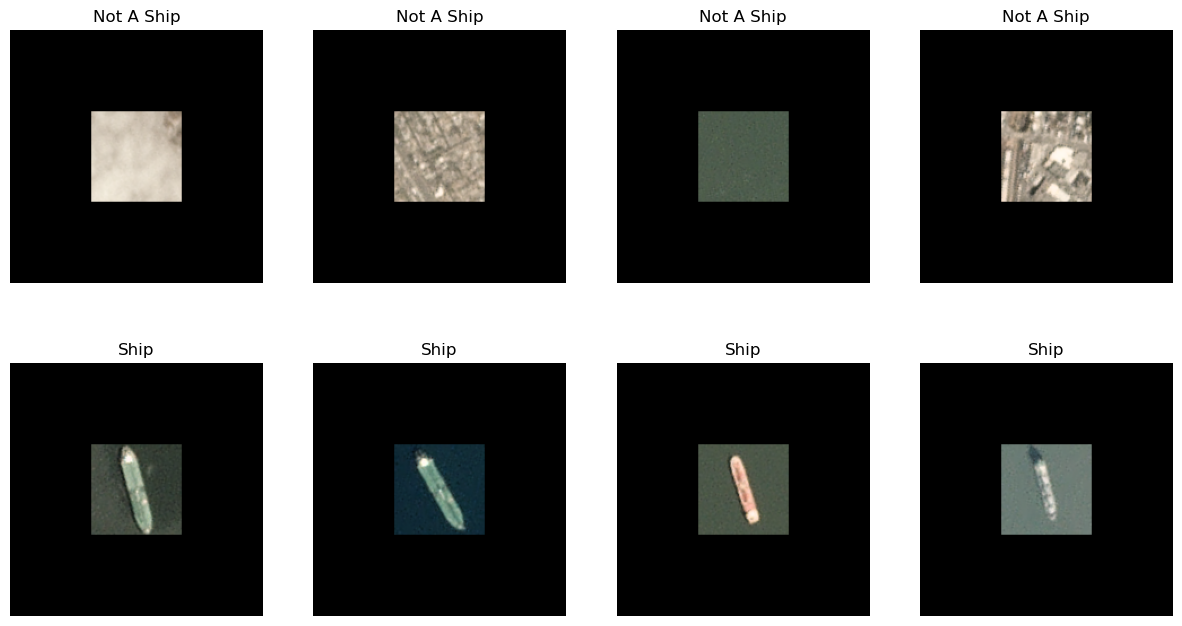

In [24]:
#Exploring the images
image_no_ship = x_reshaped[y==0]
image_ship = x_reshaped[y==1]

def plot(a,b):
    
    plt.figure(figsize=(15, 15))
    for i, k in enumerate(range(1,9)):
        if i < 4:
            plt.subplot(2,4,k)
            plt.title('Not A Ship')
            plt.imshow(image_no_ship[i+2])
            plt.axis("off")
        else:
            plt.subplot(2,4,k)
            plt.title('Ship')
            plt.imshow(image_ship[i+15])
            plt.axis("off")
            
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0.25)

#Implementation of the function 

plot(image_no_ship, image_ship)

In [25]:
#Modelling
x_reshaped = x_reshaped / 255

In [26]:
x_reshaped[0][0][0] # Normalized RGB values of the firs pixel of the first image in the dataset.

array([0., 0., 0.])

In [27]:
x_train_1, x_test, y_train_1, y_test = train_test_split(x_reshaped, y_reshaped,
                                                        test_size = 0.20, random_state = 42)


x_train, x_val, y_train, y_val = train_test_split(x_train_1, y_train_1, 
                                                  test_size = 0.25, random_state = 42)


print("x_train shape",x_train.shape)
print("x_test shape",x_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)
print("y_train shape",x_val.shape)
print("y_test shape",y_val.shape)
print("x_train_1 shape",x_train_1.shape)
print("x_val shape",x_val.shape)
print("y_train_1 shape",y_train_1.shape)

x_train shape (2400, 224, 224, 3)
x_test shape (800, 224, 224, 3)
y_train shape (2400, 2)
y_test shape (800, 2)
y_train shape (800, 224, 224, 3)
y_test shape (800, 2)
x_train_1 shape (3200, 224, 224, 3)
x_val shape (800, 224, 224, 3)
y_train_1 shape (3200, 2)


In [28]:
x_test.shape

(800, 224, 224, 3)

In [29]:
x_train.shape

(2400, 224, 224, 3)

**VGG16**

In [30]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential

# Building the model

num_classes = 2
# Initialising the model VGG 16
model = Sequential()


# Stage 1
model.add(Conv2D(input_shape = (224, 224, 3), filters = 64, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))


# Stage 2
model.add(Conv2D(filters = 128, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(Conv2D(filters = 128, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))


# Stage 3
model.add(Conv2D(filters = 256, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(Conv2D(filters = 256, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(Conv2D(filters = 256, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))


# Stage 4
model.add(Conv2D(filters = 512, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(Conv2D(filters = 512, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(Conv2D(filters = 512, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))


# Stage 5
model.add(Conv2D(filters = 512, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(Conv2D(filters = 512, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(Conv2D(filters = 512, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))


# Stage 6
model.add(Flatten())
model.add(Dense(units = 4096, activation='relu'))
model.add(Dense(units = 4096, activation='relu'))
model.add(Dense(units = num_classes, activation='softmax'))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [32]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])

In [33]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
BS=35
EPOCHS=15
# Train the model
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/15
68/68 [==============================] - 2680s 40s/step - loss: 0.5800 - accuracy: 0.7484 - val_loss: 0.5591 - val_accuracy: 0.7387
Epoch 2/15
68/68 [==============================] - 2715s 40s/step - loss: 0.5419 - accuracy: 0.7518 - val_loss: 0.5087 - val_accuracy: 0.7387
Epoch 3/15
68/68 [==============================] - 2687s 40s/step - loss: 0.4971 - accuracy: 0.7772 - val_loss: 0.3693 - val_accuracy: 0.8512
Epoch 4/15
68/68 [==============================] - 2689s 40s/step - loss: 0.4071 - accuracy: 0.8173 - val_loss: 0.2882 - val_accuracy: 0.8938
Epoch 5/15
68/68 [==============================] - 2785s 41s/step - loss: 0.3593 - accuracy: 0.8440 - val_loss: 0.2634 - val_accuracy: 0.8988
Epoch 6/15
68/68 [==============================] - 2680s 39s/step - loss: 0.3134 - accuracy: 0.8660 - val_loss: 0.2357 - val_accuracy: 0.9050
Epoch 7/15
68/68 [==============================] - 2678s 39s/step - loss: 0.2985 - accuracy: 0.8786 - val_loss: 0.2467 - val_accuracy: 0.8913

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
from sklearn import metrics
import seaborn as sns
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# Compute the confusion matrix

print("\n""Test Accuracy Score : ",metrics.accuracy_score(Y_true, Y_pred_classes),"\n")

fig, axis = plt.subplots(1, 3, figsize=(20,6))
axis[0].plot(history.history['val_accuracy'], label='val_acc')
axis[0].set_title("Validation Accuracy")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Val. Acc.")
axis[1].plot(history.history['accuracy'], label='acc')
axis[1].set_title("Training Accuracy")
axis[1].set_xlabel("Epochs")
axis[0].set_ylabel("Train. Acc.")
axis[2].plot(history.history['val_loss'], label='val_loss')
axis[2].set_title("Test Loss")
axis[2].set_xlabel("Epochs")
axis[2].set_ylabel("Loss")

plt.show()


confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Plot the confusion matrix
f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()

plt.show()

In [ ]:
pd.DataFrame(history.history).plot();

In [ ]:
prediction = model.predict(x_test)
pd.Series(prediction[0], index=["Not A Ship", "Ship"])

In [ ]:
predicted_data = pd.DataFrame(prediction, columns=["Not A Ship", "Ship"])
predicted_data.head()

In [ ]:
y_test_data = pd.DataFrame(y_test, columns=["Not A Ship", "Ship"])
y_test_data.head()

In [ ]:
predicted_data['There is a Ship'] = y_test[:, 1]
predicted_data.head()

In [ ]:
predicted_data["Difference"] = predicted_data["Ship"] - predicted_data["There is a Ship"]
predicted_data

In [ ]:
predicted_data.sort_values('Difference', ascending=False).head(10)

In [ ]:
indexes = predicted_data.sort_values('Difference', ascending = False).head(4).index.to_list()

def plotHistogram(image_index):

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(x_test[image_index])
    plt.axis('off')
    plt.title('There is no ship. But predicted as a ship.')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(x_test[image_index][:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()


for i in indexes:
    plotHistogram(i)
